In [49]:
import processed_data_generator as pdg
import pandas as pd
from datetime import datetime, timedelta

start_time = datetime(2025, 1, 30, 23, 45)
end_time = datetime(2025, 1, 2, 0, 0)
time_interval = timedelta(minutes=15)


data = pdg.generate_fake_parking_data(start_time, end_time, time_interval, [1,2,3])


df = pd.DataFrame(data)

df['timestamp'] = pd.to_datetime(df['timestamp'])
#df.set_index('timestamp', inplace=True)

df['total_capacity'] = df['occupancy'] + df['vacancy']
df['relative_occupancy'] = df['occupancy'] / df['total_capacity']


# Round timestamps to the nearest hour
df['rounded_timestamp'] = df['timestamp'].dt.floor('h')

# Group by parking_id and rounded timestamp, then aggregate
df_aggregated = df.groupby(['parking_id', 'rounded_timestamp'], as_index=False).agg(
    mean_occupancy=('relative_occupancy', 'mean')  # Aggregate occupancy
)
df_aggregated.rename(columns={'rounded_timestamp': 'timestamp'}, inplace=True)

# Extract features
df_aggregated['hour'] = df_aggregated['timestamp'].dt.hour
df_aggregated['day_of_week'] = df_aggregated['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
df_aggregated['is_festive'] = df_aggregated['day_of_week'].apply(lambda x: 1 if x == 6 else 0)  # Sunday is festive

# Manually mark other festive days (e.g., public holidays)
festive_dates = ["2025-01-01", "2025-01-06", "2025-04-20", "2025-04-21", "2025-05-01", "2025-04-25",
                 "2025-08-15","2025-12-08","2025-12-25","2025-12-26"]  # Add other dates here
df_aggregated['is_festive'] = df_aggregated['timestamp'].dt.date.isin(pd.to_datetime(festive_dates).date) | df_aggregated['is_festive']

df_aggregated['parking_id'] = df_aggregated['parking_id'].astype(str)  # Ensure it's a string for dummies
parking_dummies = pd.get_dummies(df_aggregated['parking_id'], prefix='parking')
df_aggregated = df_aggregated.join(parking_dummies).drop(columns=['parking_id', 'timestamp'])



# Rename occupancy to mean_occupancy
df_aggregated.rename(columns={'occupancy': 'mean_occupancy'}, inplace=True)


print(df_aggregated.tail())


      mean_occupancy  hour  day_of_week  is_festive  parking_1  parking_2  \
2083        0.652778    19            3       False      False      False   
2084        0.625000    20            3       False      False      False   
2085        0.486111    21            3       False      False      False   
2086        0.555556    22            3       False      False      False   
2087        0.472222    23            3       False      False      False   

      parking_3  
2083       True  
2084       True  
2085       True  
2086       True  
2087       True  


In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import numpy as np

# Aggregate occupancy by hour
parking_data = df_aggregated

# Split into training and validation sets
train_data = parking_data[:-168]  # Last 168 hours (7 days) for validation
test_data = parking_data[-168:]

y_train = train_data['mean_occupancy']
y_test = test_data['mean_occupancy']
X_train = train_data.drop(columns=['mean_occupancy'])
X_test = test_data.drop(columns=['mean_occupancy'])

X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(X_train.mean())
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(X_test.mean())

print(X_train.dtypes)
print(X_test.dtypes)
print(y_train.dtypes)

# Fit SARIMA model (order and seasonal_order are placeholders; these need tuning)
sarima_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),                # ARIMA order: (p, d, q)
    seasonal_order=(1, 1, 1, 24), # Seasonal order: (P, D, Q, s) with weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit()

print("Now doing the forecast")
# Forecast the next 7 days (168 hours)
forecast = sarima_result.forecast(steps=168)
forecast = sarima_result.forecast(steps=168, exog=X_test)


print("evaluation time")
# Evaluate the model
mae = mean_absolute_error(y_test, forecast)
print(f"Mean Absolute Error: {mae}")




hour           int32
day_of_week    int32
is_festive      bool
parking_1       bool
parking_2       bool
parking_3       bool
dtype: object
hour           int32
day_of_week    int32
is_festive      bool
parking_1       bool
parking_2       bool
parking_3       bool
dtype: object
float64
(1920, 6)
(168, 6)
(1920,)
(168,)


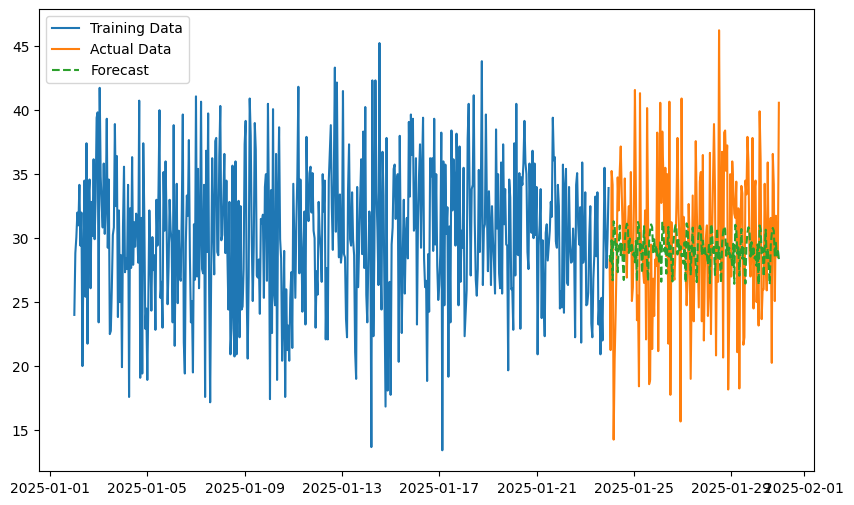

In [3]:
# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Data')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.legend()
plt.show()